<div style="display: flex; background-color: RGB(119, 150, 203);">
    <h1 style="margin: auto; padding: 30px 30px 30px 30px; color: RGB(255,255,255);">
        <center>
            <b>Regression : Prédiction d'une location d'un AirBnB</b><br/>
            <br/>
            Claire GEFFLOT<br/>
</div>

<div class="alert alert-block alert-info">
<b><u>Contexte du projet</b><br/>
<br/>
• Réalisation d’une étude<br/>
• <b>Données :</b> Caractéristiques des biens immobiliers<br/>
• <b>Objectif :</b> Trouver le meilleur modèle de regression (prédiction) permettant de prédire le prix des locations (pour 1 nuit) des biens immobiliers<br/>
• <b>Évènement cible :</b> Le "Prix de la location"<br/>
• <b>Contexte :</b> Biens immobilers à Marseille.<br/>
• Vous êtes un “touriste qui cherche une location rentable”<br/>
• <b>Variable cible :</b> price_per_night<br/>

</div>

<a class="anchor" id="table_of_contents"></a>
## Sommaire

* [Data pre-processing](#chapter1)
    * [Import des packages et data](#section_1_1)
    * [Data cleaning](#section_1_2)
* [Exploration des données (EDA)](#chapter2)
* [Feature engineering](#chapter3)
    * [Création d'indicateur (drop)](#section_3_1)
    * [Pré-sélection des variables (Chi 2 et Student) (update)](#section_3_2)
    * [Encoding et scaling (train et validation set)](#section_3_3)
    * [Sélection des variables - Regression logistique (RFE) (only for reg log)](#section_3_4)
* [Modélisation](#chapter4)
    * [Régression logistique](#section_4_1)
    * [XGBoost](#section_4_2)
    * [LightGBM](#section_4_3)
* [Choix du modèle final : XGBoost](#chapter5)
    * [Analyse des résultats (review)](#section_5_1)
    * [Identification des variables les plus importantes](#section_5_2)
    * [Interprétation du modèle](#section_5_3)
    * [Sérialisation du modèle et déploiement en situation réelle](#section_5_4)

<a class="anchor" id="chapter1"></a>
<div style="display: flex; background-color: RGB(119, 150, 203);">
    <h1 style="margin: auto; padding: 30px 30px 30px 30px; color: RGB(255,255,255);">
            <b>Data pre-processing</b>
</div>

<a class="anchor" id="section_1_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Imports des packages et data</h3>
</div>

In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype, is_object_dtype
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as st
from pathlib import Path
import io
from unidecode import unidecode
from skimpy import skim
import sys
from statistics import mean
import warnings
import re

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import category_encoders as ce
from pre_processing import pre_processing


from sklearn.exceptions import DataConversionWarning
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from catboost import cv
import optuna
import joblib

import shap

In [2]:
# Read the dataset :

pd.set_option("display.min_rows", 10)
pd.set_option("display.max_column", 1000)

df = pd.read_excel('..\\DATA\\airbnb_scraping_VF.xlsx', index_col=False) 
df=df.iloc[:, 1:]
df

,links,title,price_per_night,stars,reviews,superhost,quality_1,quality_2,quality_3,description,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,carbon_monoxide_detector,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,location,transport_access
0,https://www.airbnb.fr/rooms/28195345?adults=1&...,"Sardinette du Vallon des Auffes, maison terrasse",120,4.97,114.0,Superhôte,Arrivée autonome,Marie Et Sa Soeur Julie est Superhôte,Annulation gratuite pendant 48 heures,"La Sardinette, maison sur le port du Vallon de...",2,1.0,1,1.0,NaN,NaN,Entrée privée,Chauffage,Détecteur de fumée,Accès plage ou bord de mer,Vue sur la mer,Cuisine,Lave-linge,Sèche-linge,NaN,Climatisation,Wifi,NaN,NaN,Réfrigérateur,NaN,Four,Four à micro-ondes,Équipements de cuisine de base,Lave-vaisselle,NaN,NaN,NaN,NaN,NaN,0,32.0,NaN,NaN
1,https://www.airbnb.fr/rooms/29978931?adults=1&...,A casa chic Vallon,185,4.97,76.0,Superhôte,Patricia est Superhôte,Procédure d'arrivée irréprochable,Annulation gratuite avant le 22 août,Appartement meublé de 53 m² décoré avec soin e...,4,2.0,2,1.0,NaN,Parking gratuit dans la rue,Entrée privée,Chauffage,NaN,Accès plage ou bord de mer,Vue sur la mer,Cuisine,Lave-linge,Sèche-linge,NaN,Climatisation,Wifi,NaN,Télévision,Réfrigérateur,Congélateur,Four,Four à micro-ondes,Équipements de cuisine de base,Lave-vaisselle,NaN,NaN,NaN,NaN,NaN,0,53.0,NaN,oui
2,https://www.airbnb.fr/rooms/36093763?adults=1&...,Le 16 sur Vieux port,92,4.82,33.0,Superhôte,Luce Et Jean-Louis Laurent est Superhôte,Procédure d'arrivée irréprochable,Annulation gratuite avant le 26 août,"Sur le Quai de Rive Neuve (Vieux Port), UNIQUE...",4,1.0,2,1.0,NaN,NaN,Entrée privée,Chauffage,Détecteur de fumée,Accès plage ou bord de mer,NaN,Cuisine,Lave-linge,NaN,NaN,Climatisation,Wifi,NaN,Télévision,Réfrigérateur,NaN,NaN,Four à micro-ondes,Équipements de cuisine de base,Lave-vaisselle,NaN,NaN,NaN,NaN,NaN,0,45.0,vieux port,oui
3,https://www.airbnb.fr/rooms/32160450?adults=1&...,"VILLA KENNEDY - Jacuzzi, Corniche- Plages",463,4.85,160.0,Superhôte,Arrivée autonome,Francois est Superhôte,Annulation gratuite pendant 48 heures,Cette belle villa d’architecte vous offre l’ex...,6,2.0,4,1.5,NaN,Parking gratuit dans la rue,Entrée privée,NaN,Détecteur de fumée,Accès plage ou bord de mer,Vue sur la mer,Cuisine,NaN,NaN,NaN,NaN,Wifi,NaN,Télévision,Réfrigérateur,Congélateur,Four,Four à micro-ondes,Équipements de cuisine de base,Lave-vaisselle,NaN,Arrière-cour,NaN,NaN,NaN,0,NaN,NaN,NaN
4,https://www.airbnb.fr/rooms/3332149?adults=1&c...,T2 grand confort endoume 7ème,61,4.73,97.0,NaN,Arrivée autonome,Procédure d'arrivée irréprochable,Annulation gratuite avant le 25 août,Deux pièces 30 m2 ambiance bord de mer refait ...,3,1.0,2,1.0,NaN,Parking gratuit dans la rue,NaN,Chauffage,Détecteur de fumée,NaN,NaN,Cuisine,Lave-linge,NaN,NaN,NaN,Wifi,NaN,Télévision,Réfrigérateur,NaN,Four,Four à micro-ondes,Équipements de cuisine de base,Lave-vaisselle,NaN,NaN,NaN,NaN,NaN,0,30.0,endoume,oui
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,https://www.airbnb.fr/rooms/50632439?adults=1&...,Magnifique villa avec piscine prox. mer-callan...,260,5.00,3.0,NaN,Idéalement situé,Procédure d'arrivée irréprochable,Annulation gratuite avant le 25 août,"Bienvenue chez nous, une villa à louer pour le...",6,3.0,4,2.0,NaN,Parking gratuit dans la rue,Entrée privée,NaN,Détecteur de fumée,NaN,NaN,Cuisine,Lave-linge,NaN,NaN,NaN,Wifi,Animaux acceptés,Télévision,Réfrigérateur,Congélateur,Four,Four à micro-ondes,Équipements de cuisine de base,Lave-vaisselle,NaN,NaN,Espace de travail dédié,NaN,NaN,1,110.0,périer,oui
296,https://www.airbnb.fr/rooms/580313337431848596...,"

<a class="anchor" id="section_1_2"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Exploration des données</h3>
</div>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   links                     300 non-null    object 
 1   title                     300 non-null    object 
 2   price_per_night           300 non-null    int64  
 3   stars                     221 non-null    float64
 4   reviews                   242 non-null    float64
 5   superhost                 73 non-null     object 
 6   quality_1                 297 non-null    object 
 7   quality_2                 220 non-null    object 
 8   quality_3                 165 non-null    object 
 9   description               299 non-null    object 
 10  traveler                  300 non-null    int64  
 11  room                      281 non-null    float64
 12  bed                       300 non-null    int64  
 13  bathroom                  300 non-null    float64
 14  free_parki

In [4]:
def df_analyse(df, columns, name_df):
    """
    Initial analysis on the DataFrame.

    Parameters
    ----------
    Args:
        df (pandas.DataFrame): DataFrame to analyze.
        columns (list): Dataframe keys in list format.
        name_df (str): DataFrame name.

    Returns:
        None.
        Print the initial analysis on the DataFrame.
    """

    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]

    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        # identifying empty columns
        empty_cols = [col for col in df.columns if df[col].isna().all()]
        #identifying full duplicates rows
        df_rows_duplicates = df[df.duplicated()]

        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict()
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["Name", "Type"])
        df_resume["Records"] = list(df.count())
        df_resume["% of NaN"] = list(round((df.isnull().sum(axis = 0))/len(df),5)*100)
        df_resume["Unique"] = list(df.nunique())


        print("\nInitial Analysis of", name_df, "dataset")
        print("--------------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        #print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None

        print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                    print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")

        print("\n- Type object and records by columns         (",memory_usage,")")
        print("--------------------------------------------------------------------------")
        print(df_resume.sort_values("Records", ascending=False))



# Analyse df
df_analyse(df, ["price_per_night"], "df")


Initial Analysis of df dataset
--------------------------------------------------------------------------
- Dataset shape:                  300 rows and 44 columns
- Total of NaN values:            5082
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         1
  + The empty column is:          ['carbon_monoxide_detector']

- The key(s): ['price_per_night'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns         ( memory usage: 103.3+ KB )
--------------------------------------------------------------------------
                        Name     Type  Records  % of NaN  Unique
0                      links   object      300     0.000     300
12                       bed    int64      300     0.000       8
2            price_per_night    int64      300     0.000     152
40             swimming_pool    int64      300     0.000       2
1                      title   obj

<a class="anchor" id="section_1_3"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Data cleaning</h3>
</div

<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: black; ">Traitements basiques des données</h3>
</div

In [5]:
#drop duplicate : 
df.duplicated().value_counts()
df.drop_duplicates(inplace=True, keep="first")

In [6]:
#drop useless columns:
df.drop(['title', 'links', 'description', 'quality_1', 'quality_2', 'quality_3'], axis=1, inplace=True)

In [7]:
#Handling data formatting: Data formatting involves making sure that the data is in a consistent format. It can be handled by converting data types, changing date formats, etc.
#lowercase caracter :
df = df.applymap(lambda s:s.lower() if type(s) == str else s) 

#drop white space :
df = df.applymap(lambda s:s.strip() if type(s) == str else s) 

#drop multiple(double, triple) space :
df = df.applymap(lambda s:s.replace("  ", " ") if type(s) == str else s) 

#replace " " by "_" :
df = df.applymap(lambda s:s.replace(" ", "_") if type(s) == str else s) 

#remove accent :
from unidecode import unidecode
df = df.applymap(lambda s: unidecode(s) if type(s) == str else s) 

In [8]:
df

,price_per_night,stars,reviews,superhost,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,carbon_monoxide_detector,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,location,transport_access
0,120,4.97,114.0,superhote,2,1.0,1,1.0,NaN,NaN,entree_privee,chauffage,detecteur_de_fumee,acces_plage_ou_bord_de_mer,vue_sur_la_mer,cuisine,lave-linge,seche-linge,NaN,climatisation,wifi,NaN,NaN,refrigerateur,NaN,four,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,NaN,NaN,NaN,NaN,0,32.0,NaN,NaN
1,185,4.97,76.0,superhote,4,2.0,2,1.0,NaN,parking_gratuit_dans_la_rue,entree_privee,chauffage,NaN,acces_plage_ou_bord_de_mer,vue_sur_la_mer,cuisine,lave-linge,seche-linge,NaN,climatisation,wifi,NaN,television,refrigerateur,congelateur,four,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,NaN,NaN,NaN,NaN,0,53.0,NaN,oui
2,92,4.82,33.0,superhote,4,1.0,2,1.0,NaN,NaN,entree_privee,chauffage,detecteur_de_fumee,acces_plage_ou_bord_de_mer,NaN,cuisine,lave-linge,NaN,NaN,climatisation,wifi,NaN,television,refrigerateur,NaN,NaN,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,NaN,NaN,NaN,NaN,0,45.0,vieux_port,oui
3,463,4.85,160.0,superhote,6,2.0,4,1.5,NaN,parking_gratuit_dans_la_rue,entree_privee,NaN,detecteur_de_fumee,acces_plage_ou_bord_de_mer,vue_sur_la_mer,cuisine,NaN,NaN,NaN,NaN,wifi,NaN,television,refrigerateur,congelateur,four,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,arriere-cour,NaN,NaN,NaN,0,NaN,NaN,NaN
4,61,4.73,97.0,NaN,3,1.0,2,1.0,NaN,parking_gratuit_dans_la_rue,NaN,chauffage,detecteur_de_fumee,NaN,NaN,cuisine,lave-linge,NaN,NaN,NaN,wifi,NaN,television,refrigerateur,NaN,four,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,NaN,NaN,NaN,NaN,0,30.0,endoume,oui
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,260,5.00,3.0,NaN,6,3.0,4,2.0,NaN,parking_gratuit_dans_la_rue,entree_privee,NaN,detecteur_de_fumee,NaN,NaN,cuisine,lave-linge,NaN,NaN,NaN,wifi,animaux_acceptes,television,refrigerateur,congelateur,four,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,NaN,espace_de_travail_dedie,NaN,NaN,1,110.0,perier,oui
296,490,NaN,NaN,NaN,6,3.0,4,2.0,parking_gratuit_sur_place,parking_gratuit_dans_la_rue,entree_privee,NaN,detecteur_de_fumee,NaN,vue_sur_la_mer,cuisine,NaN,NaN,NaN,NaN,wifi,NaN,NaN,refrigerateur,congelateur,four,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,NaN,espace_de_travail_dedie,NaN,NaN,0,NaN,pointe_rouge,NaN
297,90,NaN,NaN,NaN,4,1.0,1,1.0,parking_gratuit_sur_place,parking_gratuit_dans_la_rue,entree_privee,NaN,NaN,NaN,NaN,cuisine,NaN,NaN,NaN,climatisation,wifi,NaN,television,refrigerateur,NaN,NaN,four_a_micro-ondes,equipements_de_cuisine_de_base,NaN,logement_fumeur,NaN,NaN,NaN,patio_ou_balcon,0,NaN,NaN,NaN
298,347,5.00,3.0,NaN,7,4.0,4,1.5,parking_gratuit_sur_place,NaN,entree_privee,chauffage,detecteur_de_fumee,NaN,NaN,cuisine,lave-linge,NaN,NaN,NaN,wifi,animaux_acceptes,television,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,montredon,NaN


In [9]:
# study the type and the number of unique value of each covariate
df_nunique = pd.concat([df.nunique(dropna=False), df.dtypes], axis=1).rename(columns={0: 'nunique', 1: 'dtypes'})
df_nunique

,nunique,dtypes
price_per_night,152,int64
stars,50,float64
reviews,87,float64
superhost,2,object
traveler,10,int64
room,7,float64
bed,8,int64
bathroom,6,float64
free_parking_on_site,2,object
free_street_parking,2,object


In [10]:
#drop columns which have only 1 unique value :
df.drop(['carbon_monoxide_detector'], axis=1, inplace=True)

<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: black; ">Traitements des valeurs anormales</h3>
</div

In [11]:
# analyse if there is any anomaly before fillna : until PASS_AFTERGRACE_IND_M1
df_describe = (df.describe()).T
df_describe

,count,mean,std,min,25%,50%,75%,max
price_per_night,300.0,217.130000,131.135126,50.0,112.75,192.00,290.00,750.0
stars,221.0,4.807873,0.194634,4.0,4.74,4.85,4.96,5.0
reviews,242.0,34.037190,45.824610,1.0,6.00,16.00,44.00,355.0
traveler,300.0,5.266667,2.082469,2.0,4.00,5.00,6.00,11.0
room,281.0,2.558719,1.179106,1.0,2.00,2.00,3.00,6.0
bed,300.0,3.133333,1.488716,1.0,2.00,3.00,4.00,8.0
bathroom,300.0,1.568333,0.782007,1.0,1.00,1.00,2.00,5.0
swimming_pool,300.0,0.273333,0.446415,0.0,0.00,0.00,1.00,1.0
surface,120.0,104.358333,56.693751,16.0,60.00,100.00,140.00,240.0


In [ ]:
# Voir s'il y a des anomalies pour les var categorielles :
# display(df["var_cat"].unique())

Aucune erreurs à signaler sur ces variables :


<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: black; ">Transformation des variables</h3>
</div

In [12]:
#handle cat and binary columns :
df[df.select_dtypes(include=['object']).columns.tolist()]

,superhost,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,location,transport_access
0,superhote,NaN,NaN,entree_privee,chauffage,detecteur_de_fumee,acces_plage_ou_bord_de_mer,vue_sur_la_mer,cuisine,lave-linge,seche-linge,climatisation,wifi,NaN,NaN,refrigerateur,NaN,four,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,superhote,NaN,parking_gratuit_dans_la_rue,entree_privee,chauffage,NaN,acces_plage_ou_bord_de_mer,vue_sur_la_mer,cuisine,lave-linge,seche-linge,climatisation,wifi,NaN,television,refrigerateur,congelateur,four,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,NaN,NaN,NaN,NaN,NaN,oui
2,superhote,NaN,NaN,entree_privee,chauffage,detecteur_de_fumee,acces_plage_ou_bord_de_mer,NaN,cuisine,lave-linge,NaN,climatisation,wifi,NaN,television,refrigerateur,NaN,NaN,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,NaN,NaN,NaN,NaN,vieux_port,oui
3,superhote,NaN,parking_gratuit_dans_la_rue,entree_privee,NaN,detecteur_de_fumee,acces_plage_ou_bord_de_mer,vue_sur_la_mer,cuisine,NaN,NaN,NaN,wifi,NaN,television,refrigerateur,congelateur,four,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,arriere-cour,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,parking_gratuit_dans_la_rue,NaN,chauffage,detecteur_de_fumee,NaN,NaN,cuisine,lave-linge,NaN,NaN,wifi,NaN,television,refrigerateur,NaN,four,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,NaN,NaN,NaN,NaN,endoume,oui
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,NaN,NaN,parking_gratuit_dans_la_rue,entree_privee,NaN,detecteur_de_fumee,NaN,NaN,cuisine,lave-linge,NaN,NaN,wifi,animaux_acceptes,television,refrigerateur,congelateur,four,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,NaN,espace_de_travail_dedie,NaN,NaN,perier,oui
296,NaN,parking_gratuit_sur_place,parking_gratuit_dans_la_rue,entree_privee,NaN,detecteur_de_fumee,NaN,vue_sur_la_mer,cuisine,NaN,NaN,NaN,wifi,NaN,NaN,refrigerateur,congelateur,four,four_a_micro-ondes,equipements_de_cuisine_de_base,lave-vaisselle,NaN,NaN,espace_de_travail_dedie,NaN,NaN,pointe_rouge,NaN
297,NaN,parking_gratuit_sur_place,parking_gratuit_dans_la_rue,entree_privee,NaN,NaN,NaN,NaN,cuisine,NaN,NaN,climatisation,wifi,NaN,television,refrigerateur,NaN,NaN,four_a_micro-ondes,equipements_de_cuisine_de_base,NaN,logement_fumeur,NaN,NaN,NaN,patio_ou_balcon,NaN,NaN
298,NaN,parking_gratuit_sur_place,NaN,entree_privee,chauffage,detecteur_de_fumee,NaN,NaN,cuisine,lave-linge,NaN,NaN,wifi,animaux_acceptes,television,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,montredon,NaN


In [13]:
target = "price_per_night"
list_cont_binary_col = df.select_dtypes(include=['object']).columns.tolist()
list_cont_binary_col = [col for col in list_cont_binary_col if df[col].nunique(dropna=False) == 2 and col != target]
list_cont_binary_col

['superhost',
 'free_parking_on_site',
 'free_street_parking',
 'private_entrance',
 'heating',
 'smoke_detector',
 'access_sea',
 'seaview',
 'kitchen',
 'washing_machine',
 'dryer',
 'AC',
 'wifi',
 'accepted_animals',
 'tv',
 'fridge',
 'freezer',
 'oven',
 'microwave_oven',
 'basic_kitchen_equipment',
 'dishwasher',
 'smoker',
 'backyard',
 'workspace',
 'private_garden',
 'patio_or_balcony',
 'transport_access']

In [14]:
df[list_cont_binary_col] = df[list_cont_binary_col].replace(regex={r'\D+': 1})
df

,price_per_night,stars,reviews,superhost,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,location,transport_access
0,120,4.97,114.0,1.0,2,1.0,1,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0,32.0,NaN,NaN
1,185,4.97,76.0,1.0,4,2.0,2,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0,53.0,NaN,1.0
2,92,4.82,33.0,1.0,4,1.0,2,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0,45.0,vieux_port,1.0
3,463,4.85,160.0,1.0,6,2.0,4,1.5,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,0,NaN,NaN,NaN
4,61,4.73,97.0,NaN,3,1.0,2,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0,30.0,endoume,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,260,5.00,3.0,NaN,6,3.0,4,2.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1,110.0,perier,1.0
296,490,NaN,NaN,NaN,6,3.0,4,2.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,0,NaN,pointe_rouge,NaN
297,90,NaN,NaN,NaN,4,1.0,1,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,0,NaN,NaN,NaN
298,347,5.00,3.0,NaN,7,4.0,4,1.5,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,montredon,NaN


<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: black; ">Analyse des données après nettoyage</h3>
</div

In [15]:
df_describe = (df.describe()).T
df_describe

,count,mean,std,min,25%,50%,75%,max
price_per_night,300.0,217.130000,131.135126,50.0,112.75,192.00,290.00,750.0
stars,221.0,4.807873,0.194634,4.0,4.74,4.85,4.96,5.0
reviews,242.0,34.037190,45.824610,1.0,6.00,16.00,44.00,355.0
superhost,73.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.0
traveler,300.0,5.266667,2.082469,2.0,4.00,5.00,6.00,11.0
room,281.0,2.558719,1.179106,1.0,2.00,2.00,3.00,6.0
bed,300.0,3.133333,1.488716,1.0,2.00,3.00,4.00,8.0
bathroom,300.0,1.568333,0.782007,1.0,1.00,1.00,2.00,5.0
free_parking_on_site,163.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.0
free_street_parking,168.0,1.000000,0.000000,1.0,1.00,1.00,1.00,1.0


In [ ]:
skim(df)


<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: black; ">Imputation des valeurs manquantes</h3>
</div

In [16]:
#see which col have NaN value :
df_na = (pd.DataFrame(df.isna().sum())).rename(columns={0: 'Sum_NaN'})
df_na

,Sum_NaN
price_per_night,0
stars,79
reviews,58
superhost,227
traveler,0
room,19
bed,0
bathroom,0
free_parking_on_site,137
free_street_parking,132


Afin d'éviter tout biais au sein de nos ensembles de données lors des imputations de valeurs manquantes, nous procédons immédiatement au split.

### Split data

In [17]:
target = "price_per_night"

num_bins = 10  # Number of bins for stratification
y_bins = pd.cut(df[target], bins=num_bins, labels=False)
df_train, df_val = train_test_split(df, test_size=0.25, stratify=y_bins, random_state=10) #, stratify=y_bins

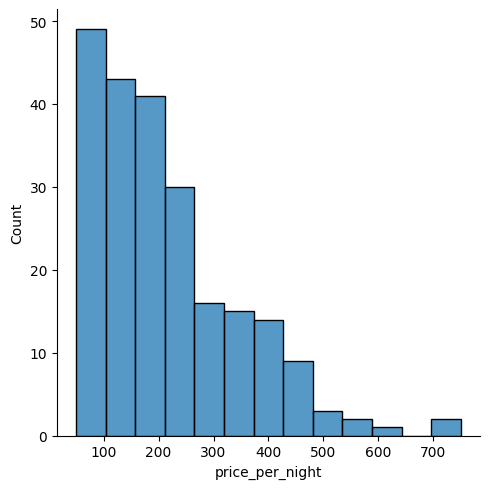

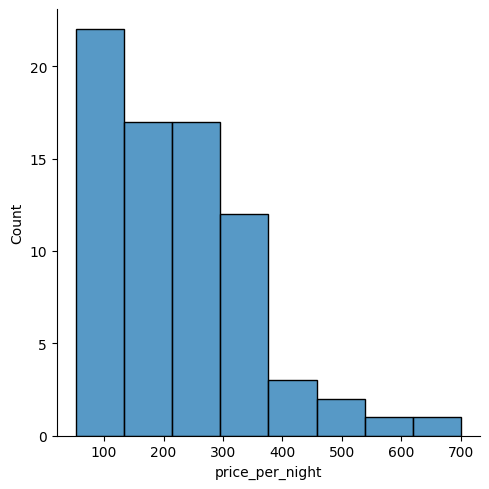

In [18]:
#verify the distrib
import seaborn as sns
sns.displot(df_train[target])
sns.displot(df_val[target])

In [19]:
df_train.reset_index(drop = True, inplace=True)
df_val.reset_index(drop = True, inplace=True)

df_train

,price_per_night,stars,reviews,superhost,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,location,transport_access
0,214,4.78,82.0,NaN,4,1.0,1,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0,60.0,vallon_des_auffes,NaN
1,300,NaN,NaN,NaN,6,3.0,5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
2,395,NaN,2.0,NaN,6,3.0,3,2.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1,NaN,NaN,NaN
3,450,5.00,3.0,NaN,9,5.0,8,3.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
4,80,4.67,38.0,NaN,2,1.0,1,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,0,NaN,panier,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,50,4.74,55.0,NaN,3,1.0,2,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,0,NaN,NaN,1.0
221,450,4.86,7.0,NaN,8,4.0,5,3.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0,NaN,roucas_blanc,NaN
222,150,4.75,4.0,NaN,4,2.0,3,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,0,60.0,NaN,NaN
223,63,NaN,NaN,NaN,2,1.0,1,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,1.0


### Traitement df_train

In [20]:
#1/ fillna : (mean, median,...)
#(USELESS because every NaN value means than the values are equal 0, it's not the unknowns values)

#1.1/ Drop rows and col which are more 60-70% of NaN.
#If there is 50%-60% or more NaN, drop the column.
#df_train_na_col = (pd.DataFrame(((df_train.isna().sum(axis=0))/len(df_train))*100)).rename(columns={0: 'Sum_NaN_%'})

#drop col :
#df_train.drop(columns=list((df_train_na_col[df_train_na_col["Sum_NaN_%"]>50]).index), inplace=True)

#Count the number of NaN in rows :
#If there is 60-70% or more NaN, drop the row.
#df_train_na_row = (pd.DataFrame(((df_train.isna().sum(axis=1))/len(df_train.columns))*100)).rename(columns={0: 'Sum_NaN_%'})

#drop row :
#df_train.drop(index=list((df_train_na_row[df_train_na_row["Sum_NaN_%"]>60]).index), inplace=True)

#reset_index :
#df_train.reset_index(drop = True, inplace=True)

#df_train

In [21]:
#1.2/ dectect col which have NaN
df_train_na = (pd.DataFrame(df_train.isna().sum())).rename(columns={0: 'Sum_NaN'})
df_train_na_egal_0 = df_train_na[df_train_na['Sum_NaN']==0]
df_train_na_diff_0 = df_train_na[df_train_na['Sum_NaN']!=0]

In [22]:
df_train_na_diff_0

,Sum_NaN
stars,59
reviews,42
superhost,171
room,16
free_parking_on_site,105
free_street_parking,101
private_entrance,106
heating,79
smoke_detector,60
access_sea,152


In [23]:
#1.3/Build groupby df for fillna :
#select best col for groupby fillna :
target = "price_per_night"
corr_matrix = df_train[list(df_train_na_egal_0.index)].corr().abs().loc[target].drop([target], axis=0)

In [24]:
corr_matrix = pd.concat([corr_matrix, df_train[list(corr_matrix.index)].nunique()], axis=1).rename(columns={0: 'nunique'})
corr_matrix.sort_values(by=[target]) #, "nunique"

,price_per_night,nunique
swimming_pool,0.431931,2
bed,0.547424,8
bathroom,0.604397,6
traveler,0.622549,10


Les variables (sans NaN) les plus corrélées à la target avec un nombre réduit de modalités sont :
- traveler
- bathroom
- bed

In [25]:
df_train_grouby_3var = df_train.groupby(["traveler", "bathroom", "bed"])
df_train_grouby_2var = df_train.groupby(["traveler", "bathroom"])
df_train_grouby_1var = df_train.groupby(["traveler"])

In [26]:
df_train_grouby_3var.size().reset_index(name='count')

,traveler,bathroom,bed,count
0,2,1.0,1,18
1,2,1.0,2,3
2,2,1.5,1,1
3,2,2.0,2,1
4,3,1.0,1,3
...,...,...,...,...
63,10,2.0,5,1
64,10,2.0,6,1
65,10,3.0,5,1
66,10,3.0,6,3


In [27]:
df_train

,price_per_night,stars,reviews,superhost,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,location,transport_access
0,214,4.78,82.0,NaN,4,1.0,1,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0,60.0,vallon_des_auffes,NaN
1,300,NaN,NaN,NaN,6,3.0,5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
2,395,NaN,2.0,NaN,6,3.0,3,2.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1,NaN,NaN,NaN
3,450,5.00,3.0,NaN,9,5.0,8,3.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
4,80,4.67,38.0,NaN,2,1.0,1,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,0,NaN,panier,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,50,4.74,55.0,NaN,3,1.0,2,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,0,NaN,NaN,1.0
221,450,4.86,7.0,NaN,8,4.0,5,3.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0,NaN,roucas_blanc,NaN
222,150,4.75,4.0,NaN,4,2.0,3,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,0,60.0,NaN,NaN
223,63,NaN,NaN,NaN,2,1.0,1,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,1.0


In [28]:
list_median_mode_imputation = ["stars", "room", "surface"]
list_cat_particular_imputation = ["location"]
list_cont_particular_imputation = [i for i in list(df_train.columns) if i not in list_median_mode_imputation + list_cat_particular_imputation + [target] + ["traveler", "bathroom", "bed"]]

list_cont_particular_imputation

['reviews',
 'superhost',
 'free_parking_on_site',
 'free_street_parking',
 'private_entrance',
 'heating',
 'smoke_detector',
 'access_sea',
 'seaview',
 'kitchen',
 'washing_machine',
 'dryer',
 'AC',
 'wifi',
 'accepted_animals',
 'tv',
 'fridge',
 'freezer',
 'oven',
 'microwave_oven',
 'basic_kitchen_equipment',
 'dishwasher',
 'smoker',
 'backyard',
 'workspace',
 'private_garden',
 'patio_or_balcony',
 'swimming_pool',
 'transport_access']

In [29]:
len(list_cont_particular_imputation) + len(list_median_mode_imputation) + len(list_cat_particular_imputation) + 1

34

In [30]:
#1.4/fillna on dataset : 

# numerical col :
#warnings.filterwarnings('ignore')

#fillna with particular value :
#df_train["var"] = df_train["var"].fillna("numerical_value")
df_train[list_cont_particular_imputation] = df_train[list_cont_particular_imputation].fillna(0)


#fillna with median :
target = "price_per_night"
for i in list_median_mode_imputation : # or (df_train_na_diff_0.index) 
    if is_numeric_dtype(df_train[i]) and i != target :
        df_train[i] = df_train_grouby_3var[i].fillna(df_train[i].median()) # equivalence : df_train.groupby(["traveler", "bathroom", "bed"])[i].fillna(df_train[i].median())
        df_train[i] = df_train_grouby_2var[i].fillna(df_train[i].median())
        df_train[i] = df_train_grouby_1var[i].fillna(df_train[i].median())

        df_train[i] = df_train[i].fillna(df_train[i].median())

print(df_train.isna().sum())

price_per_night              0
stars                        0
reviews                      0
superhost                    0
traveler                     0
room                         0
bed                          0
bathroom                     0
free_parking_on_site         0
free_street_parking          0
private_entrance             0
heating                      0
smoke_detector               0
access_sea                   0
seaview                      0
kitchen                      0
washing_machine              0
dryer                        0
AC                           0
wifi                         0
accepted_animals             0
tv                           0
fridge                       0
freezer                      0
oven                         0
microwave_oven               0
basic_kitchen_equipment      0
dishwasher                   0
smoker                       0
backyard                     0
workspace                    0
private_garden               0
patio_or

In [31]:
#categorical col :

#fillna with particular value :
#df_train["var"] = df_train["var"].fillna("string_value")
df_train[list_cat_particular_imputation].fillna("unknown", inplace=True)


#fillna with mode :
target = "price_per_night"
for i in list_median_mode_imputation : # or (df_train_na_diff_0.index) :
    if is_object_dtype(df_train[i]) and i != target :
        df_train[i] = df_train_grouby_3var[i].fillna(df_train[i].mode()[0]) ##df_train.groupby(["PASS_GRACE_IND_M1", "PASS_GRACE_IND_M2", "PASS_AFTERGRACE_IND_M2"])[i].fillna(df_train[i].mode())
        df_train[i] = df_train_grouby_2var[i].fillna(df_train[i].mode()[0])
        df_train[i] = df_train_grouby_1var[i].fillna(df_train[i].mode()[0])
        
        df_train[i] = df_train[i].fillna(df_train[i].mode()[0])

print(df_train.isna().sum())

price_per_night            0
stars                      0
reviews                    0
superhost                  0
traveler                   0
room                       0
bed                        0
bathroom                   0
free_parking_on_site       0
free_street_parking        0
private_entrance           0
heating                    0
smoke_detector             0
access_sea                 0
seaview                    0
kitchen                    0
washing_machine            0
dryer                      0
AC                         0
wifi                       0
accepted_animals           0
tv                         0
fridge                     0
freezer                    0
oven                       0
microwave_oven             0
basic_kitchen_equipment    0
dishwasher                 0
smoker                     0
backyard                   0
workspace                  0
private_garden             0
patio_or_balcony           0
swimming_pool              0
surface       

In [32]:
df_train_na_col = (pd.DataFrame(((df_train.isna().sum(axis=0))/len(df_train))*100)).rename(columns={0: 'Sum_NaN_%'})

In [33]:
df_train

,price_per_night,stars,reviews,superhost,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,location,transport_access
0,214,4.780,82.0,0.0,4,1.0,1,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,60.0,vallon_des_auffes,0.0
1,300,4.845,0.0,0.0,6,3.0,5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,99.0,unknown,0.0
2,395,4.845,2.0,0.0,6,3.0,3,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1,99.0,unknown,0.0
3,450,5.000,3.0,0.0,9,5.0,8,3.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,99.0,unknown,0.0
4,80,4.670,38.0,0.0,2,1.0,1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,99.0,panier,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,50,4.740,55.0,0.0,3,1.0,2,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,99.0,unknown,1.0
221,450,4.860,7.0,0.0,8,4.0,5,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,99.0,roucas_blanc,0.0
222,150,4.750,4.0,0.0,4,2.0,3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,60.0,unknown,0.0
223,63,4.845,0.0,0.0,2,1.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,99.0,unknown,1.0


### Traitement df_val

In [34]:
#1.1/ verify if columns (which we use for groupby) have NaN or not :
groupby_columns = ["traveler", "bathroom", "bed"]
df_val[groupby_columns].isna().sum(axis=0)

traveler    0
bathroom    0
bed         0
dtype: int64

In [35]:
# if there is NaN, fillna them by the median/mean or mode from df_train

#numerical col :
for i in groupby_columns :
    df_val[i] = df_val[i].fillna(df_train[i].median())

#cat col :
for i in groupby_columns :
    df_val[i] = df_val[i].fillna(df_train[i].mode())

In [36]:
#1.2/dectect col which have NaN
df_val_na = (pd.DataFrame(df_val.isna().sum())).rename(columns={0: 'Sum_NaN'})
df_val_na_egal_0 = df_val_na[df_val_na['Sum_NaN']==0]
df_val_na_diff_0 = df_val_na[df_val_na['Sum_NaN']!=0]

In [37]:
#1.2/fillna on dataset :

#numerical col :
#warnings.filterwarnings('ignore')

#fillna with particular value :
#df_val["var"] = df_val["var"].fillna("numerical_value")
df_val[list_cont_particular_imputation] = df_val[list_cont_particular_imputation].fillna(0)


#fillna with median :
target = "price_per_night"

def imputate_missing_3val(df) :
    if pd.isna(df[i]) :
        return (df_train_grouby_3var.get_group(("traveler"==df["traveler"], "bathroom"==df["bathroom"], "bed"==df["bed"]))[[elem for elem in df_val.columns if is_numeric_dtype(df_val[elem])]].agg("median"))[i]
    else :
        return df[i]
    
def imputate_missing_2val(df) :
    if pd.isna(df[i]) :
        return (df_train_grouby_2var.get_group(("traveler"==df["traveler"], "bathroom"==df["bathroom"]))[[elem for elem in df_val.columns if is_numeric_dtype(df_val[elem])]].agg("median"))[i]
    else :
        return df[i]

def imputate_missing_1val(df) :
    if pd.isna(df[i]) :
        return (df_train_grouby_1var.get_group(("traveler"==df["traveler"]))[[elem for elem in df_val.columns if is_numeric_dtype(df_val[elem])]].agg("median"))[i]
    else :
        return df[i]

for i in list_median_mode_imputation :
    if is_numeric_dtype(df_val[i]) and i != target :
        df_val[i] = df_val.apply(imputate_missing_3val, axis=1)
        df_val[i] = df_val.apply(imputate_missing_2val, axis=1)
        df_val[i] = df_val.apply(imputate_missing_1val, axis=1)
        df_val[i] = df_val[i].fillna(df_train[i].median())


pd.DataFrame(df_val.isna().sum()).sort_values(by=[0])

,0
price_per_night,0
tv,0
fridge,0
freezer,0
oven,0
microwave_oven,0
basic_kitchen_equipment,0
accepted_animals,0
dishwasher,0
backyard,0


In [38]:
#caterical col :
from pandas.api.types import is_numeric_dtype, is_object_dtype
import warnings
warnings.filterwarnings('ignore')


#fillna with particular value :
#df_val["var"] = df_val["var"].fillna("string_value")
df_val['location'].fillna("unknown", inplace=True)


#fillna with mode :
target = "AFTERGRACE_FLAG"

def imputate_missing_3val(df) :
    if pd.isna(df[i]) :
        return (df_train_grouby_3var.get_group(("traveler"==df["traveler"], "bathroom"==df["bathroom"],
                                                "bed"==df["bed"]))[[elem for elem in df_val.columns if is_object_dtype(df_val[elem])]].agg("mode"))[i][0]
    else :
        return df[i]
    
def imputate_missing_2val(df) :
    if pd.isna(df[i]) :
        return (df_train_grouby_2var.get_group(("traveler"==df["traveler"],
                                                "bathroom"==df["bathroom"]))[[elem for elem in df_val.columns if is_object_dtype(df_val[elem])]].agg("mode"))[i][0]
    else :
        return df[i]

def imputate_missing_1val(df) :
    if pd.isna(df[i]) :
        return (df_train_grouby_1var.get_group(("traveler"==df["traveler"]))[[elem for elem in df_val.columns if is_object_dtype(df_val[elem])]].agg("mode"))[i][0]
    else :
        return df[i]
    

for i in list_median_mode_imputation :
    if is_object_dtype(df_val[i]) and i != target :
        if df_val[i].isnull().values.any() :
            df_val[i] = df_val.apply(imputate_missing_3val, axis=1)
            df_val[i] = df_val.apply(imputate_missing_2val, axis=1)
            df_val[i] = df_val.apply(imputate_missing_1val, axis=1)
            df_val[i] = df_val[i].fillna(df_train[i].mode())



pd.DataFrame(df_val.isna().sum()).sort_values(by=[0])

,0
price_per_night,0
accepted_animals,0
tv,0
fridge,0
freezer,0
oven,0
microwave_oven,0
basic_kitchen_equipment,0
dishwasher,0
smoker,0


In [39]:
df_val.head()

,price_per_night,stars,reviews,superhost,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,location,transport_access
0,259,4.845,0.0,0.0,6,2.0,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,99.0,bonneveine,0.0
1,259,4.710,28.0,0.0,10,4.0,5,1.5,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,99.0,unknown,0.0
2,360,4.845,0.0,0.0,6,3.0,4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,115.0,roucas_blanc,0.0
3,455,4.000,4.0,0.0,5,3.0,4,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1,130.0,vallon_des_auffes,0.0
4,214,4.920,12.0,1.0,6,2.0,3,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,99.0,montredon,1.0


### Traitement df_test
Ici on utilise que le val, donc pas de traitement sur df_test

<a class="anchor" id="chapter2"></a>
<div style="display: flex; background-color: RGB(119, 150, 203);">
    <h1 style="margin: auto; padding: 30px 30px 30px 30px; color: RGB(255,255,255);">
            <b>Exploration data analysis (EDA) on df_train</b>
</div>

In [ ]:
skim(df_train)

In [ ]:
"""
# Création d'un DataFrame pour stocker les types de données des colonnes dans df
info_types = pd.DataFrame(df.dtypes, columns=['type'])
info_types.sort_values('type')  # Tri par la colonne 'type'

# Définition de la variable cible
target = "price_per_night"

# Sélection des colonnes numériques à l'exclusion de la variable cible
var_num = df.select_dtypes(include=np.number).columns.tolist()
var_num.remove("price_per_night")

# Sélection des colonnes catégorielles à l'exclusion de la variable CURR_HANDSET_MODE
var_cat = df.select_dtypes(include=object).columns.tolist()
var_cat = [i for i in var_cat if i not in ['title', 'links', 'description']] 
"""

In [ ]:
"""
# Définition d'une fonction pour tracer la distribution d'une variable catégorielle par rapport à la variable cible
def distrib_for_cat_by_target(var_cat: list, dataframe, target: str):
    temp = dataframe.copy()
    temp['Frequency'] = 0
    counts = temp.groupby([target, var_cat]).count()
    freq_per_group = counts.div(counts.groupby(target).transform('sum')).reset_index()
    g = sns.catplot(x=target, y="Frequency", hue=var_cat, data=freq_per_group, kind="bar",
                  height=8, aspect=2, legend=False)
    ax = g.ax
    for p in ax.patches:
        ax.annotate(f"{p.get_height()*100:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=14, color='black', xytext=(0, 20),
                    textcoords='offset points')
    plt.title("Distribution de '" + var_cat + "' par 'Cible'", fontsize=22)
    plt.legend(fontsize=14)
    plt.xlabel(target, fontsize=18)
    plt.ylabel('Fréquence', fontsize=18)
    plt.show()

# Tracer la distribution des variables catégorielles par rapport à la variable
for i in var_cat:
    distrib_for_cat_by_target(i,df,target)
"""

In [ ]:
"""
warnings.filterwarnings("ignore")

# Définition d'une fonction pour tracer la distribution d'une variable numérique par rapport à la variable cible
def distrib_for_num_by_target(var_num: list, dataframe, target: str):
    
    Fonction de distribution d'une variable explicative selon la variable cible (x|y)
    var_num : variable explicative à étudier
    dataframe
    target : variable cible
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 7))
    sns.distplot(dataframe[dataframe[target] == 0][var_num], ax=ax1)
    sns.distplot(dataframe[dataframe[target] == 1][var_num], ax=ax2)
    ax1.set_title("Distribution de la variable " + var_num + f" \n pour '{target}' = 0")
    ax2.set_title("Distribution de la variable " + var_num + f" \n pour '{target}' = 1")
    plt.show()

# Tracer la distribution des variables numériques par rapport à la variable cible

for i in var_num:
    distrib_for_num_by_target(i, df, target)
"""

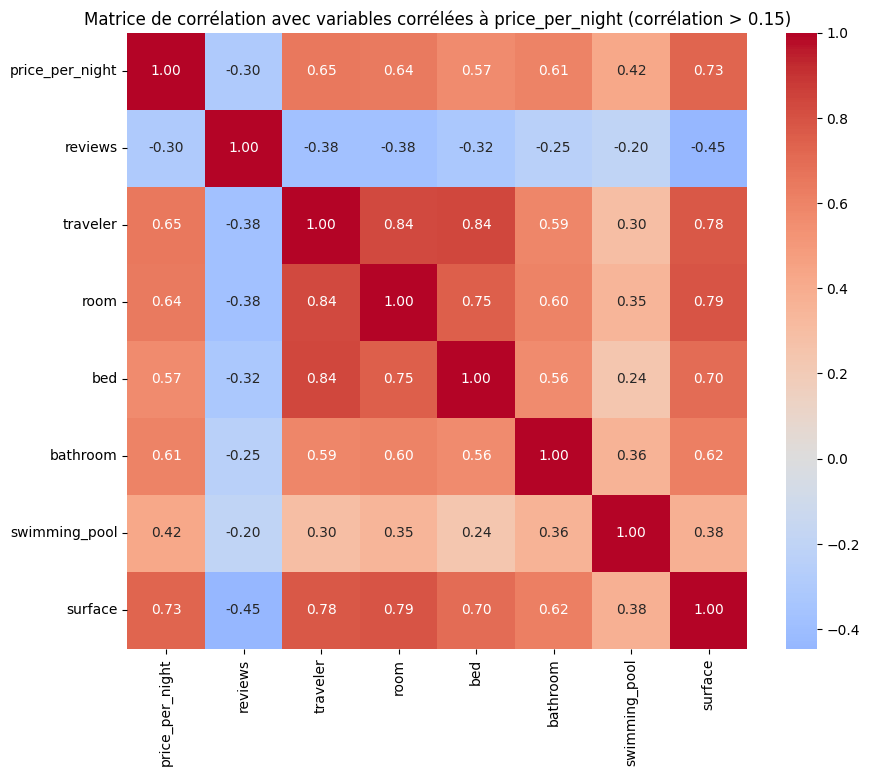

In [41]:
# Matrice de corrélation
correlation_matrix = df.corr()

# Sélection des variables les plus corrélées à AFTERGRACE_FLAG avec une corrélation supérieure à 0.15
threshold = 0.15
target_correlations = correlation_matrix['price_per_night'][(correlation_matrix['price_per_night'] > threshold) | (correlation_matrix['price_per_night'] < -threshold)]

# Filtrage du DataFrame original pour les variables sélectionnées
filtered_df = df[target_correlations.index]

# Création d'une nouvelle matrice de corrélation avec les variables sélectionnées
filtered_correlation_matrix = filtered_df.corr()

# Création de la heatmap de la matrice de corrélation filtrée
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", annot_kws={"ha": 'center'})
plt.title("Matrice de corrélation avec variables corrélées à price_per_night (corrélation > 0.15)")
plt.show()


<a class="anchor" id="chapter3"></a>
<div style="display: flex; background-color: RGB(119, 150, 203);">
    <h1 style="margin: auto; padding: 30px 30px 30px 30px; color: RGB(255,255,255);">
            <b>Feature engineering</b>
</div>

<a class="anchor" id="section_3_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Création d'indicateur</h3>
</div>

Pour les données d'entraînement :

In [42]:
# Useless

Pour les données de test/validation

In [43]:
# Useless

<a class="anchor" id="section_3_2"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Pré-sélection des variables (filter methods)</h3>
</div>

In [44]:
# Variables explicatives catégorielles avec var cible continue, test du ANOVA:
info_types = pd.DataFrame(df_train.dtypes)
list_var_cat = info_types[info_types[0]=="object"].index.tolist()
list_col_to_drop = []

target = "price_per_night"
for v in list_var_cat:
    if v != target:
        cont = df_train[[v, target]].copy()  # Extract the columns of interest
        groups = []
        for group, data in cont.groupby(v):
            groups.append(data[target].values)
        
        st_f, st_p = stats.f_oneway(*groups)
        
        # Column to drop:
        if st_p >= 0.05:
            list_col_to_drop.append(v)

        #print(v + ": p-value test chi 2 = " + str(st_p))

In [45]:
# Variables explicatives numerique et target numeric : RFE (realisé un peu plus tard)

In [46]:
list_col_to_drop

[]

In [47]:
df_train.drop(list_col_to_drop, axis=1, inplace=True)
df_val.drop(list_col_to_drop, axis=1, inplace=True)

<a class="anchor" id="section_3_3"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Encoding et scaling (train et validation set)</h3>
</div>

In [48]:
x_train = df_train.drop([target], axis=1)
y_train = df_train[target]

x_val = df_val.drop([target], axis=1)
y_val = df_val[target]

In [49]:
x_train

,stars,reviews,superhost,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,location,transport_access
0,4.780,82.0,0.0,4,1.0,1,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,60.0,vallon_des_auffes,0.0
1,4.845,0.0,0.0,6,3.0,5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,99.0,unknown,0.0
2,4.845,2.0,0.0,6,3.0,3,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1,99.0,unknown,0.0
3,5.000,3.0,0.0,9,5.0,8,3.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,99.0,unknown,0.0
4,4.670,38.0,0.0,2,1.0,1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,99.0,panier,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,4.740,55.0,0.0,3,1.0,2,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,99.0,unknown,1.0
221,4.860,7.0,0.0,8,4.0,5,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,99.0,roucas_blanc,0.0
222,4.750,4.0,0.0,4,2.0,3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,60.0,unknown,0.0
223,4.845,0.0,0.0,2,1.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,99.0,unknown,1.0


In [50]:
#numeric and > 2 :
list_cont_col = x_train.select_dtypes(include=[np.number]).columns.tolist()
list_cont_col = [col for col in list_cont_col if x_train[col].nunique() > 2]
len(list_cont_col)

7

In [51]:
#numeric and <= 2 :
list_binary_col = x_train.select_dtypes(include=[np.number]).columns.tolist()
list_binary_col = [col for col in list_binary_col if x_train[col].nunique() <= 2]
len(list_binary_col)

28

In [52]:
#categorical col :
#list_cat_col = x_train.select_dtypes(include=['object']).columns.tolist()
list_cat_col_OHE = []
list_cat_col_TE =  ['location']

In [53]:
len(list_cont_col) + len(list_binary_col) + len(list_cat_col_OHE) + len(list_cat_col_TE)

36

In [54]:
sys.path.append("./pre_processing.py")
a = pre_processing()

In [55]:
#full pre processing for linear regression models : 
x_train_preprocessed = a.pre_processing(df=x_train, train=True, categorical_var_OHE= list_cat_col_OHE,
                           categorical_var_OrdinalEncoding={}, categorical_var_TE=list_cat_col_TE, target=y_train,
                           continious_var=list_cont_col, encoding_type_cont=StandardScaler())
x_train_preprocessed

,stars,reviews,superhost,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,transport_access,location
0,-0.271558,1.256496,0.0,-0.619106,-1.354873,-1.428050,-0.719655,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,-1.186722,0.0,199.867269
1,0.154344,-0.611843,0.0,0.355012,0.443631,1.168404,0.511694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.060940,0.0,214.274829
2,0.154344,-0.566274,0.0,0.355012,0.443631,-0.129823,0.511694,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1,-0.060940,0.0,214.274829
3,1.169957,-0.543489,0.0,1.816188,2.242135,3.115745,1.743042,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,-0.060940,0.0,214.274829
4,-0.992315,0.253973,0.0,-1.593223,-1.354873,-1.428050,-0.719655,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,-0.060940,1.0,196.060119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,-0.533652,0.641311,0.0,-1.106164,-1.354873,-0.778936,-0.719655,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,-0.060940,1.0,214.274829
221,0.252629,-0.452351,0.0,1.329129,1.342883,1.168404,1.743042,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,-0.060940,0.0,253.474963
222,-0.468128,-0.520704,0.0,-0.619106,-0.455621,-0.129823,-0.719655,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,-1.186722,0.0,214.274829
223,0.154344,-0.611843,0.0,-1.593223,-1.354873,-1.428050,-0.719655,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.060940,1.0,214.274829


In [56]:
x_val_preprocessed = a.pre_processing(df=x_val, train=False, categorical_var_OHE= list_cat_col_OHE,
                         categorical_var_OrdinalEncoding={}, categorical_var_TE=list_cat_col_TE, target=y_train,
                         continious_var=list_cont_col, encoding_type_cont=StandardScaler())
x_val_preprocessed

,stars,reviews,superhost,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,transport_access,location
0,0.154344,-0.611843,0.0,0.355012,-0.455621,-0.778936,-0.719655,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.060940,0.0,215.435556
1,-0.730222,0.026126,0.0,2.303246,1.342883,1.168404,-0.103980,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,-0.060940,0.0,214.274829
2,0.154344,-0.611843,0.0,0.355012,0.443631,0.519291,-0.719655,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.400920,0.0,253.474963
3,-5.382383,-0.520704,0.0,-0.132047,0.443631,0.519291,0.511694,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1,0.833913,0.0,199.867269
4,0.645769,-0.338427,1.0,0.355012,-0.455621,-0.129823,0.511694,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,-0.060940,1.0,208.222920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.154344,-0.611843,0.0,-0.619106,-1.354873,-0.778936,-0.719655,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.060940,0.0,197.260628
71,-0.009464,-0.087797,0.0,-0.132047,-0.455621,-0.129823,0.511694,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1,0.256589,0.0,198.464784
72,-0.992315,-0.475135,0.0,-0.132047,1.342883,0.519291,0.511694,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,-0.060940,1.0,214.274829
73,-0.926792,0.231188,1.0,-1.593223,-1.354873,-1.428050,-0.103980,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,-0.060940,1.0,196.931510


In [57]:
#Pre processing for boosting models :
#for boosting, we only encode categorical value.
x_train = a.pre_processing(df=x_train, train=True, categorical_var_OHE= list_cat_col_OHE,
                           categorical_var_OrdinalEncoding={}, categorical_var_TE=list_cat_col_TE, target=y_train,
                           continious_var=[], encoding_type_cont=StandardScaler())
x_train

,stars,reviews,superhost,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,transport_access,location
0,4.780,82.0,0.0,4,1.0,1,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,60.0,0.0,199.867269
1,4.845,0.0,0.0,6,3.0,5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,99.0,0.0,214.274829
2,4.845,2.0,0.0,6,3.0,3,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1,99.0,0.0,214.274829
3,5.000,3.0,0.0,9,5.0,8,3.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,99.0,0.0,214.274829
4,4.670,38.0,0.0,2,1.0,1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,99.0,1.0,196.060119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,4.740,55.0,0.0,3,1.0,2,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,99.0,1.0,214.274829
221,4.860,7.0,0.0,8,4.0,5,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,99.0,0.0,253.474963
222,4.750,4.0,0.0,4,2.0,3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,60.0,0.0,214.274829
223,4.845,0.0,0.0,2,1.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,99.0,1.0,214.274829


In [58]:
x_val = a.pre_processing(df=x_val, train=False, categorical_var_OHE= list_cat_col_OHE,
                         categorical_var_OrdinalEncoding={}, categorical_var_TE=list_cat_col_TE, target=y_train,
                         continious_var=[], encoding_type_cont=StandardScaler())
x_val

,stars,reviews,superhost,traveler,room,bed,bathroom,free_parking_on_site,free_street_parking,private_entrance,heating,smoke_detector,access_sea,seaview,kitchen,washing_machine,dryer,AC,wifi,accepted_animals,tv,fridge,freezer,oven,microwave_oven,basic_kitchen_equipment,dishwasher,smoker,backyard,workspace,private_garden,patio_or_balcony,swimming_pool,surface,transport_access,location
0,4.845,0.0,0.0,6,2.0,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,99.0,0.0,215.435556
1,4.710,28.0,0.0,10,4.0,5,1.5,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,99.0,0.0,214.274829
2,4.845,0.0,0.0,6,3.0,4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,115.0,0.0,253.474963
3,4.000,4.0,0.0,5,3.0,4,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1,130.0,0.0,199.867269
4,4.920,12.0,1.0,6,2.0,3,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,99.0,1.0,208.222920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,4.845,0.0,0.0,4,1.0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,99.0,0.0,197.260628
71,4.820,23.0,0.0,5,2.0,3,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1,110.0,0.0,198.464784
72,4.670,6.0,0.0,5,4.0,4,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,99.0,1.0,214.274829
73,4.680,37.0,1.0,2,1.0,1,1.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,99.0,1.0,196.931510


<a class="anchor" id="section_3_4"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Sélection des variables - Regression logistique (RFE)</h3>
</div>

In [59]:
# regression metrics : R2, MSE, RMSE, MAE, MAPE
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

rfe_score = {"nb_var" : 0,
             "best_score" : 0}

for i in tqdm(range(1,len(x_train_preprocessed.columns)+1)) :
    estimator = LinearRegression()
    selector = RFE(estimator, n_features_to_select=i,step=1)
    selector.fit(x_train_preprocessed,y_train)

    x_train_preprocessed_new = x_train_preprocessed[list(selector.get_feature_names_out())]
    estimator.fit(x_train_preprocessed_new, y_train)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
    skf.get_n_splits(x_train_preprocessed_new, y_train) 
    cross_val_score_ = mean(cross_val_score(estimator, x_train_preprocessed_new,y_train, cv=skf, scoring = "r2")) #other scoring : neg_mean_squared_error','neg_mean_squared_log_error'

    if cross_val_score_ > rfe_score["best_score"] :
        rfe_score["nb_var"] = i
        rfe_score["best_score"] = cross_val_score_

100%|██████████| 36/36 [00:02<00:00, 15.48it/s]


In [60]:
rfe_score

{'nb_var': 18, 'best_score': 0.5579156012400167}

In [61]:
warnings.filterwarnings('ignore')

estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=rfe_score['nb_var'], step=1)
selector.fit(x_train_preprocessed,y_train)

print(list(selector.get_feature_names_out()))

['traveler', 'bathroom', 'free_parking_on_site', 'free_street_parking', 'heating', 'seaview', 'AC', 'wifi', 'accepted_animals', 'tv', 'microwave_oven', 'smoker', 'backyard', 'workspace', 'private_garden', 'swimming_pool', 'surface', 'transport_access']


In [62]:
# Linear model :
x_train_preprocessed = x_train_preprocessed[list(selector.get_feature_names_out())]
x_val_preprocessed = x_val_preprocessed[list(selector.get_feature_names_out())]

# Boosting model :
x_train = x_train[list(selector.get_feature_names_out())]
x_val = x_val[list(selector.get_feature_names_out())]

x_train

,traveler,bathroom,free_parking_on_site,free_street_parking,heating,seaview,AC,wifi,accepted_animals,tv,microwave_oven,smoker,backyard,workspace,private_garden,swimming_pool,surface,transport_access
0,4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,60.0,0.0
1,6,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,99.0,0.0
2,6,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1,99.0,0.0
3,9,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,99.0,0.0
4,2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,99.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,3,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,99.0,1.0
221,8,3.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,99.0,0.0
222,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0,60.0,0.0
223,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,99.0,1.0


In [63]:
#save the x_train for using shapley value in app.py :
x_train.to_csv(path_or_buf="../DATA/x_train.csv", sep=';', index=False)

<a class="anchor" id="chapter4"></a>
<div style="display: flex; background-color: RGB(119, 150, 203);">
    <h1 style="margin: auto; padding: 30px 30px 30px 30px; color: RGB(255,255,255);">
            <b>Modélisation</b>
</div>

<a class="anchor" id="section_4_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Régression logistique</h3>
</div>

### Modélisation naïve

In [63]:
lr = LinearRegression()
lr.fit(x_train_preprocessed, y_train)
print(lr.score(x_train_preprocessed, y_train)) # replace scoring='accuracy' by "recall"  #or roc_auc
print(lr.score(x_val_preprocessed, y_val)) # replace scoring='accuracy' by "recall"  #or roc_auc

0.6364727865492553
0.6400333487408607


### r2_score

In [64]:
#r2_score
print(r2_score(y_train, lr.predict(x_train_preprocessed))) #, multi_class='ovr'
print(r2_score(y_val, lr.predict(x_val_preprocessed))) #, multi_class='ovr'

0.6364727865492553
0.6400333487408607


In [65]:
#Cross_val_score :
from sklearn.model_selection import cross_val_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train_preprocessed, y_train) 
mean(cross_val_score(lr, x_train_preprocessed, y_train, cv=skf, scoring = "r2")) #other scoring : neg_mean_squared_error','neg_mean_squared_log_error'

0.5579156012400167

### MSE

In [66]:
#mse or rmse
print(mean_squared_error(y_train, lr.predict(x_train_preprocessed))) #, multi_class='ovr'
print(mean_squared_error(y_val, lr.predict(x_val_preprocessed))) #, multi_class='ovr'

6066.495793283101
6644.3824540087335


In [67]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train_preprocessed, y_train)

-(cross_val_score(lr, x_train_preprocessed, y_train, cv=skf, scoring='neg_mean_squared_error').mean()) #other scoring : neg_mean_squared_error','neg_mean_squared_log_error'

7243.105183852228

### MAE

In [68]:
#mean absolute error
print(mean_absolute_error(y_train, lr.predict(x_train_preprocessed))) #, multi_class='ovr'
print(mean_absolute_error(y_val, lr.predict(x_val_preprocessed))) #, multi_class='ovr'

58.37567446278672
62.757674446847325


In [69]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train_preprocessed, y_train)

-(cross_val_score(lr, x_train_preprocessed, y_train, cv=skf, scoring='neg_mean_absolute_error').mean()) #other scoring : neg_mean_squared_error','neg_mean_absolute_error'

63.02720095720955

### MAPE

In [70]:
#mse or rmse
print(mean_absolute_percentage_error(y_train, lr.predict(x_train_preprocessed))) #, multi_class='ovr'
print(mean_absolute_percentage_error(y_val, lr.predict(x_val_preprocessed))) #, multi_class='ovr'

0.3334863359735878
0.3637595709406484


In [71]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
skf.get_n_splits(x_train_preprocessed, y_train)

-(cross_val_score(lr, x_train_preprocessed, y_train, cv=skf, scoring='neg_mean_absolute_percentage_error').mean()) #other scoring : neg_mean_squared_error','neg_mean_absolute_error'

0.3602813186902083

### Optimisation des hyperparamètres

In [72]:
# No hyper-param to optimize in linear regression

<a class="anchor" id="section_4_2"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">XGBoost</h3>
</div>

### Modélisation naïve

In [73]:
lr = XGBRegressor(random_state=10) #, tree_method='gpu_hist', predictor="gpu_predictor"
lr.fit(x_train, y_train)
print(lr.score(x_train, y_train)) # replace scoring='accuracy' by "recall"  #or auc
print(lr.score(x_val, y_val)) # replace scoring='accuracy' by "recall"  #or auc

0.9988180107550284
0.557069831165713


### r2_score

In [74]:
#r2_score
print(r2_score(y_train, lr.predict(x_train))) #, multi_class='ovr'
print(r2_score(y_val, lr.predict(x_val))) #, multi_class='ovr'

0.9988180107550284
0.557069831165713


In [75]:
#Cross_val_score :
from sklearn.model_selection import cross_val_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
skf.get_n_splits(x_train, y_train) 
mean(cross_val_score(lr, x_train,y_train, cv=skf, scoring = "r2")) #other scoring : neg_mean_squared_error','neg_mean_squared_log_error'

0.4836567587665995

### MSE

In [76]:
#mse or rmse
print(mean_squared_error(y_train, lr.predict(x_train))) #, multi_class='ovr'
print(mean_squared_error(y_val, lr.predict(x_val))) #, multi_class='ovr'

19.724885832509802
8175.750258695505


In [77]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
skf.get_n_splits(x_train, y_train)

-(cross_val_score(lr, x_train, y_train, cv=skf, scoring='neg_mean_squared_error').mean()) #other scoring : neg_mean_squared_error','neg_mean_squared_log_error'

8400.7065100979

### MAE

In [78]:
#mean absolute error
print(mean_absolute_error(y_train, lr.predict(x_train))) #, multi_class='ovr'
print(mean_absolute_error(y_val, lr.predict(x_val))) #, multi_class='ovr'

1.5602016194661459
69.67139836629232


In [79]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
skf.get_n_splits(x_train, y_train)

-(cross_val_score(lr, x_train, y_train, cv=skf, scoring='neg_mean_absolute_error').mean()) #other scoring : neg_mean_squared_error','neg_mean_absolute_error'

65.27327825546264

### MAPE

In [80]:
#mse or rmse
print(mean_absolute_percentage_error(y_train, lr.predict(x_train))) #, multi_class='ovr'
print(mean_absolute_percentage_error(y_val, lr.predict(x_val))) #, multi_class='ovr'

0.010741781619532638
0.338867425874584


In [81]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
skf.get_n_splits(x_train, y_train)

-(cross_val_score(lr, x_train, y_train, cv=skf, scoring='neg_mean_absolute_percentage_error').mean()) #other scoring : neg_mean_squared_error','neg_mean_absolute_error'

0.35116981078833126

### Optimisation des hyperparamètres

In [82]:
#Bayesian Optimisation (optuna) :
def objective(trial):
    max_depth = trial.suggest_categorical('max_depth', [5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 23, 25, 28, 30, 40, 50, None]) #profondeur
    learning_rate = trial.suggest_categorical('learning_rate', [0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]) 
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1, step=0.1) #min leaf of each tree
    n_estimators = trial.suggest_int('n_estimators', 1,1000, step=50) #nb of tree
    
    model = XGBRegressor(random_state=10, max_depth=max_depth, learning_rate=learning_rate, colsample_bytree=colsample_bytree,
                        n_estimators=n_estimators)  #, tree_method='gpu_hist', predictor="gpu_predictor"

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
    skf.get_n_splits(x_train, y_train) 
    return cross_val_score(model, x_train, y_train,n_jobs=-1, cv=skf, scoring='r2').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-07-09 14:50:35,345] A new study created in memory with name: no-name-60b7f5ce-407c-436d-bac8-6e68c16bda7d
[I 2023-07-09 14:50:37,361] Trial 0 finished with value: 0.5667662642804359 and parameters: {'max_depth': 6, 'learning_rate': 0.09, 'colsample_bytree': 0.5, 'n_estimators': 401}. Best is trial 0 with value: 0.5667662642804359.
[I 2023-07-09 14:50:38,753] Trial 1 finished with value: 0.4843826353251379 and parameters: {'max_depth': 50, 'learning_rate': 0.06, 'colsample_bytree': 1.0, 'n_estimators': 551}. Best is trial 0 with value: 0.5667662642804359.
[I 2023-07-09 14:50:39,752] Trial 2 finished with value: 0.5696646515014544 and parameters: {'max_depth': 6, 'learning_rate': 0.08, 'colsample_bytree': 0.4, 'n_estimators': 601}. Best is trial 2 with value: 0.5696646515014544.
[I 2023-07-09 14:50:39,952] Trial 3 finished with value: 0.5053680707654596 and parameters: {'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.9, 'n_estimators': 351}. Best is trial 2 with valu

In [83]:
trial = study.best_trial
print('score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

score: 0.6238184522286894
Best hyperparameters: {'max_depth': 20, 'learning_rate': 0.03, 'colsample_bytree': 0.4, 'n_estimators': 151}


### Ajuster le modèle avec les meilleurs hyperparamètres

In [84]:
#model evaluation : accuracy, precision...
best_model = XGBRegressor(random_state=10, max_depth=(trial.params)["max_depth"], learning_rate=(trial.params)["learning_rate"], 
                                  colsample_bytree=(trial.params)["colsample_bytree"], n_estimators=(trial.params)["n_estimators"]) #, tree_method='gpu_hist'
best_model.fit(x_train, y_train)

display(best_model.score(x_train, y_train)) # replace scoring='accuracy' by "recall"  #or auc
display(best_model.score(x_val, y_val)) # replace scoring='accuracy' by "recall"  #or auc

0.9485142265598564

0.630328303850197

### r2_score

In [85]:
#r2_score
print(r2_score(y_train, best_model.predict(x_train))) #, multi_class='ovr'
print(r2_score(y_val, best_model.predict(x_val))) #, multi_class='ovr'

0.9485142265598564
0.630328303850197


In [86]:
#Cross_val_score :
from sklearn.model_selection import cross_val_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
skf.get_n_splits(x_train, y_train) 
mean(cross_val_score(best_model, x_train,y_train, cv=skf, scoring = "r2")) #other scoring : neg_mean_squared_error','neg_mean_squared_log_error'

0.6238184522286894

### MSE

In [87]:
#mse or rmse
print(mean_squared_error(y_train, best_model.predict(x_train))) #, multi_class='ovr'
print(mean_squared_error(y_val, best_model.predict(x_val))) #, multi_class='ovr'

859.1880234321918
6823.521354129985


In [88]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
skf.get_n_splits(x_train, y_train)

-(cross_val_score(best_model, x_train, y_train, cv=skf, scoring='neg_mean_squared_error').mean()) #other scoring : neg_mean_squared_error','neg_mean_squared_log_error'

6289.575836405292

### MAE

In [89]:
#mean absolute error
print(mean_absolute_error(y_train, best_model.predict(x_train))) #, multi_class='ovr'
print(mean_absolute_error(y_val, best_model.predict(x_val))) #, multi_class='ovr'

19.24536565144857
60.26041508992513


In [90]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
skf.get_n_splits(x_train, y_train)

-(cross_val_score(best_model, x_train, y_train, cv=skf, scoring='neg_mean_absolute_error').mean()) #other scoring : neg_mean_squared_error','neg_mean_absolute_error'

55.05484485202366

### MAPE

In [91]:
#mse or rmse
print(mean_absolute_percentage_error(y_train, best_model.predict(x_train))) #, multi_class='ovr'
print(mean_absolute_percentage_error(y_val, best_model.predict(x_val))) #, multi_class='ovr'

0.10199235693418363
0.3030637123476909


In [92]:
#cross_val_score stratifié : better than Classic Cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
skf.get_n_splits(x_train, y_train)

-(cross_val_score(best_model, x_train, y_train, cv=skf, scoring='neg_mean_absolute_percentage_error').mean()) #other scoring : neg_mean_squared_error','neg_mean_absolute_error'

0.2962806487720248

<a class="anchor" id="section_4_3"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">LightGBM</h3>
</div>

### r2_score

### MSE

### MAE

### MAPE

### Optimisation des hyperparamètres

### Ajuster le modèle avec les meilleurs hyperparamètres

### r2_score

### MSE

### MAE

### MAPE

<a class="anchor" id="chapter5"></a>
<div style="display: flex; background-color: RGB(119, 150, 203);">
    <h1 style="margin: auto; padding: 30px 30px 30px 30px; color: RGB(255,255,255);">
            <b>Choix du modèle final : XGBoost</b>
</div>

<a class="anchor" id="section_5_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Analyse des résultats (on df_val/test)</h3>
</div>

<a class="anchor" id="section_5_2"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Identification des variables les plus importantes</h3>
</div>

In [93]:
(pd.DataFrame({'Features': best_model.feature_names_in_,
              'Features importance (in %)': (best_model.feature_importances_)*100})).sort_values(by='Features importance (in %)', ascending=False)

,Features,Features importance (in %)
1,bathroom,30.064880
15,swimming_pool,13.704638
0,traveler,9.570356
5,seaview,6.366712
2,free_parking_on_site,4.939521
16,surface,4.284742
14,private_garden,4.108126
13,workspace,3.609709
6,AC,2.902760
7,wifi,2.820132


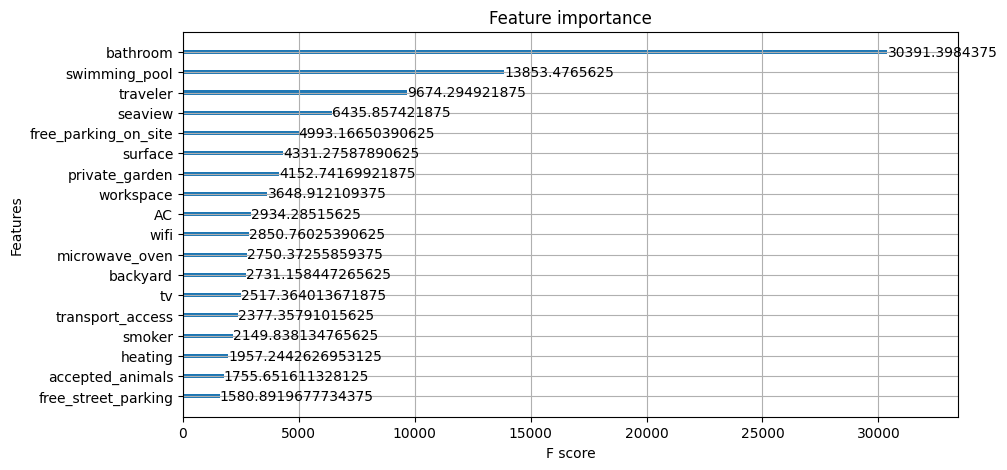

In [94]:
from matplotlib import pyplot
from xgboost import plot_importance
import matplotlib.pyplot as plt

ax = plot_importance(best_model, importance_type="gain")
fig = ax.figure
fig.set_size_inches(10, 5)

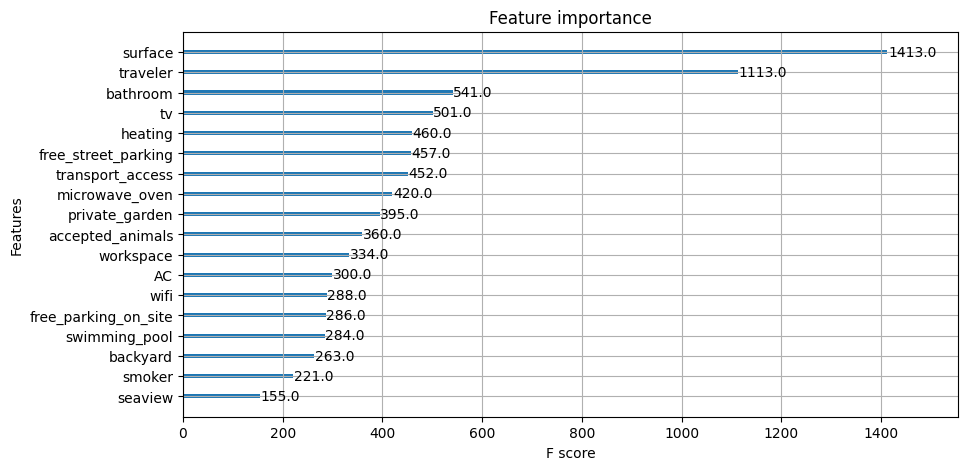

In [95]:
from matplotlib import pyplot
from xgboost import plot_importance
import matplotlib.pyplot as plt

ax = plot_importance(best_model)
fig = ax.figure
fig.set_size_inches(10, 5)

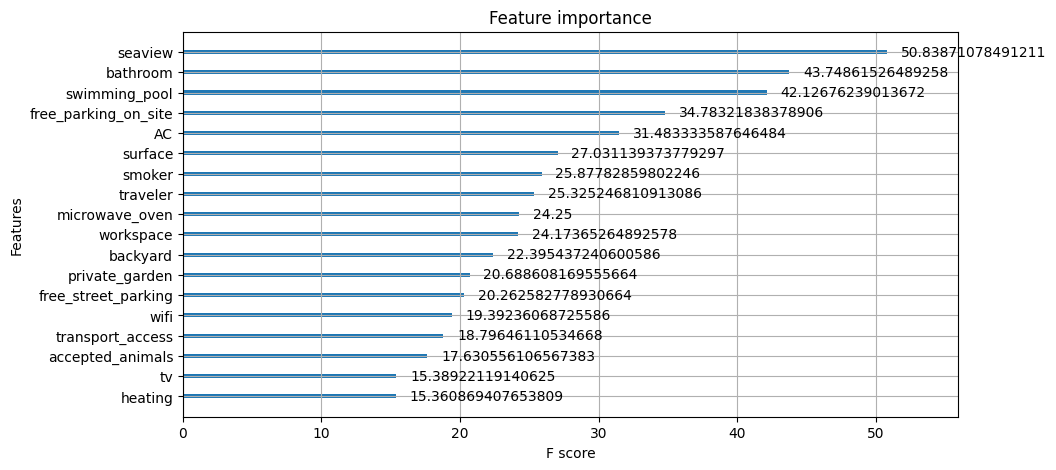

In [96]:
from matplotlib import pyplot
from xgboost import plot_importance
import matplotlib.pyplot as plt

ax = plot_importance(best_model, importance_type="cover")
fig = ax.figure
fig.set_size_inches(10, 5)

# Learning curve :

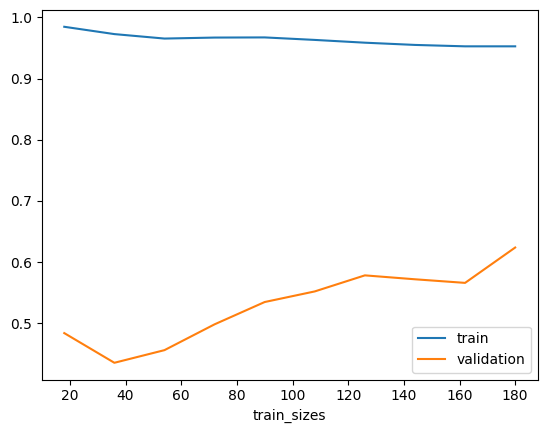

In [97]:
#add tool box
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
skf.get_n_splits(x_train, y_train)
N, train_score, val_score = learning_curve(best_model, x_train, y_train, train_sizes= np.linspace(0.1,1,10) ,cv=skf, scoring="r2") #or f1_weighted

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

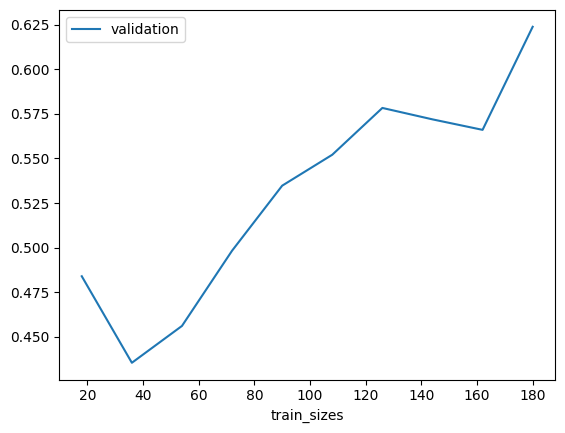

In [98]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
skf.get_n_splits(x_train, y_train)
N, train_score, val_score = learning_curve(best_model, x_train, y_train, train_sizes= np.linspace(0.1,1,10) ,cv=skf, scoring="r2")

#plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

<a class="anchor" id="section_5_3"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Interprétation du modèle</h3>
</div>

In [115]:
#General :
# compute the SHAP values for the linear model
explainer = shap.Explainer(best_model.predict, x_train)
shap_values = explainer(x_train)

Permutation explainer: 226it [00:17,  5.60it/s]                         


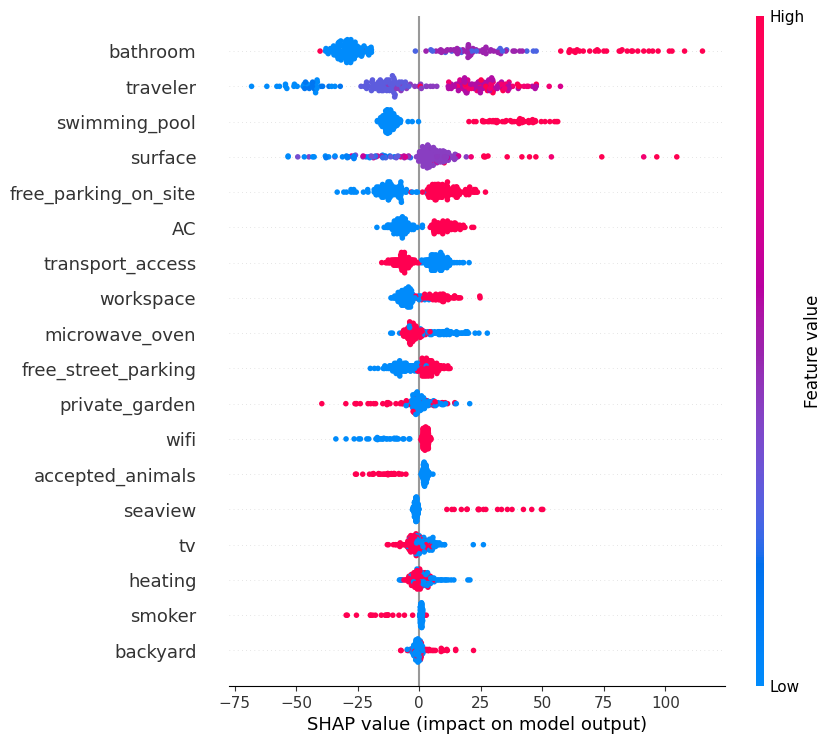

In [116]:
shap.plots.beeswarm(shap_values, max_display=20)

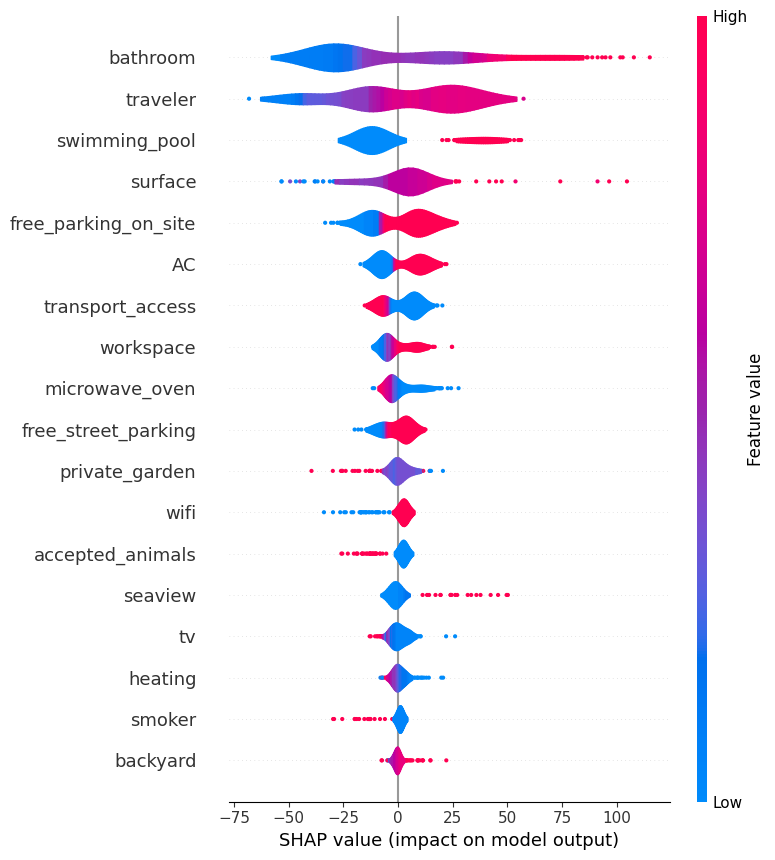

In [117]:
shap.summary_plot(shap_values, plot_type='violin', max_display=20)

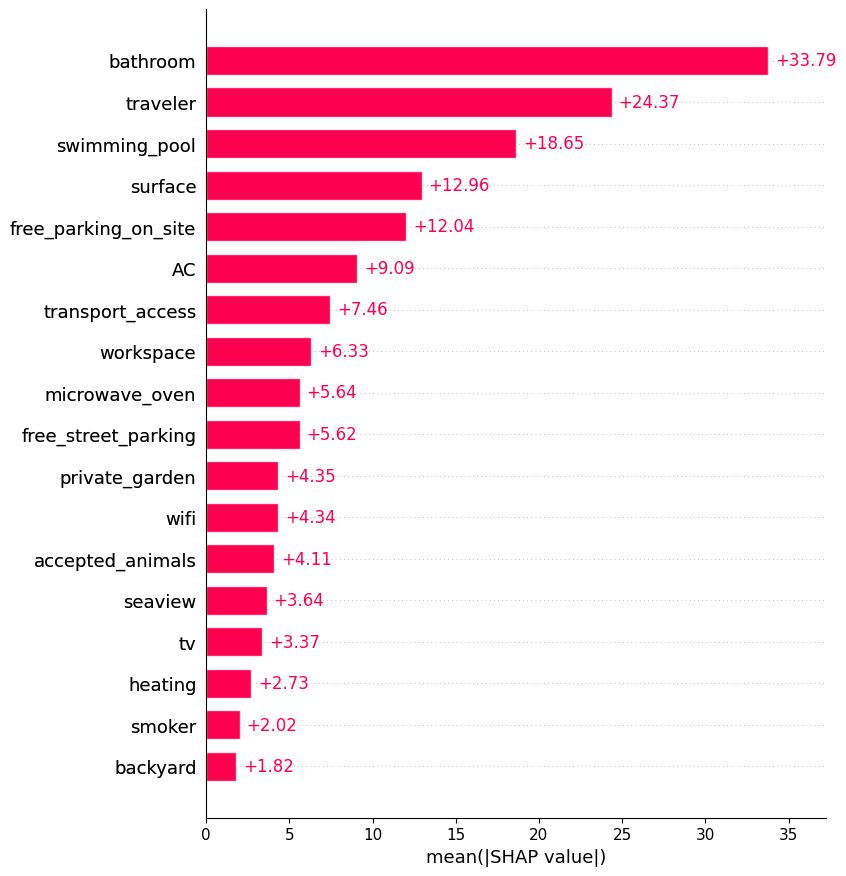

In [118]:
shap.plots.bar(shap_values, max_display=20)

<a class="anchor" id="section_5_4"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Sérialisation du modèle et déploiement en situation réelle</h3>
</div>

In [103]:
#Save the model :

joblib.dump(value = best_model, filename = '../MODEL/reg_model.pkl')

['../MODEL/reg_model.pkl']

In [3]:
#load model :
reg_model = joblib.load(filename = '../MODEL/reg_model.pkl')

## Prédiction sur un bien en particulier :

In [107]:
#predict price :
def predict_location(model, feature_dict):

    df_for_pred = pd.DataFrame(feature_dict)

    """
    df_for_pred = a.pre_processing(df=df_for_pred, train=False, categorical_var_OHE= list_cat_col_OHE, 
                           categorical_var_OrdinalEncoding={}, categorical_var_TE= list_cat_col_TE, 
                           target=y_train, continious_var=list_cont_col, encoding_type_cont=MinMaxScaler()) 

    df_for_pred = df_for_pred[list(selector.get_feature_names_out())]
    """
    return {"Price" : (model.predict(df_for_pred))[0]}, df_for_pred


In [108]:
x_train.head(1)

,traveler,bathroom,free_parking_on_site,free_street_parking,heating,seaview,AC,wifi,accepted_animals,tv,microwave_oven,smoker,backyard,workspace,private_garden,swimming_pool,surface,transport_access
0,4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,60.0,0.0


In [119]:
#example of prediction on random observation :
feature_dict = {'traveler': [4],'bathroom': [3], 'free_parking_on_site': [0],'free_street_parking': [0], 'heating': [1],
                'seaview': [1], 'AC': [1],'wifi': [1], 'accepted_animals': [1], 'tv': [1],'microwave_oven': [1], 
                'smoker': [0], "backyard":[1], "workspace":[1], 'private_garden': [1],
                'swimming_pool': [1], 'surface': [100],'transport_access': [1]}

predict_location(reg_model, feature_dict)[0]

{'Price': 243.76898}

## Explication du résultat avec Shapley value

In [120]:
df_p_h = predict_location(reg_model, feature_dict)[1]
df_p_h

,traveler,bathroom,free_parking_on_site,free_street_parking,heating,seaview,AC,wifi,accepted_animals,tv,microwave_oven,smoker,backyard,workspace,private_garden,swimming_pool,surface,transport_access
0,4,3,0,0,1,1,1,1,1,1,1,0,1,1,1,1,100,1


In [121]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(reg_model.predict, x_train)
shap_values = explainer(df_p_h)

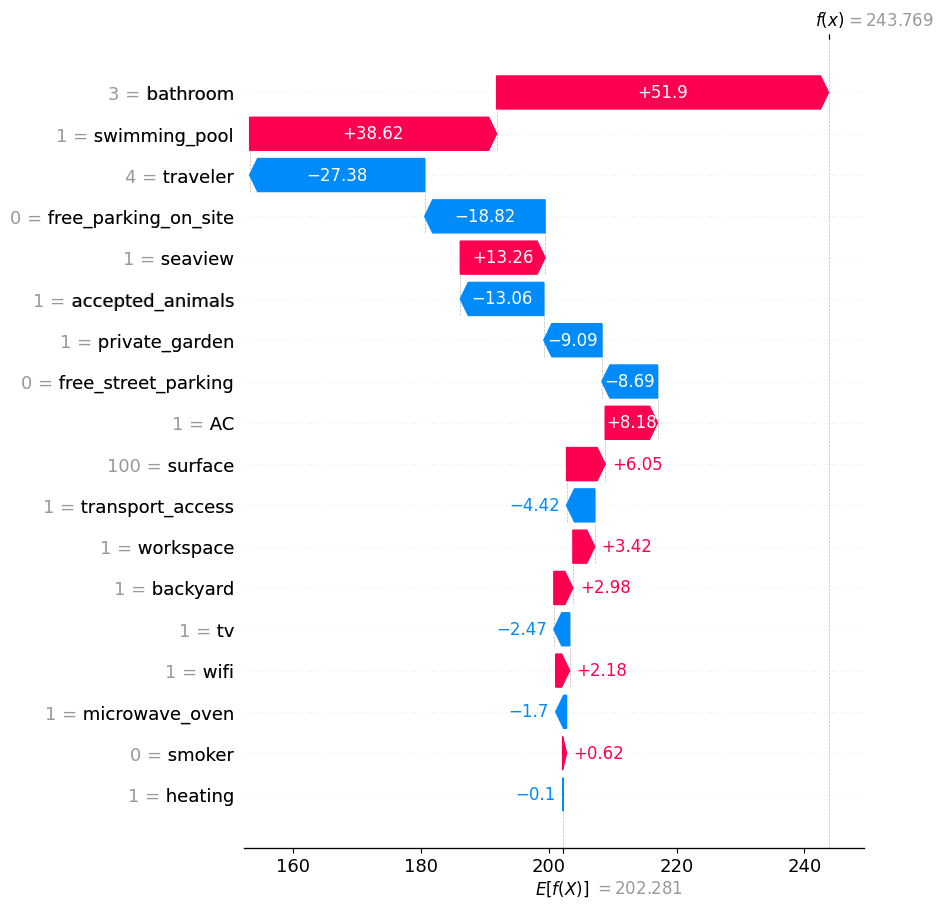

In [122]:
#particular

#The additive nature of Shapley values
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[0], max_display=20)  

In [123]:
shap.initjs()
shap.plots.force(shap_values[0])